## Notebook for Solar Wind Exploration

In the initial phase, we want to see if we can detect FTEs using unsupervised learning, by finding a manifold for the solar wind data.

The initial hypothesis is the transition matrices (Markov Matrices $M$) that can be derived from Manifolder + clustering will show distinctive clusters and transitions.  We can check accuracy by looking at the label (FTE or not?), and see if this label could have been deduced from the data itself.



In [1]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np

np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

# import seaborn as sns
# sns.set()

import pandas as pd

import time

import random

import os

### Load Solar Wind Data, and Run Manifolder

The `dataset_2` file contains 

Dataset-2 (THEMIS):   a list with FTEs periods and non-FTEs periods observed by THEMIS in 2007.  These are combined into one file, randomly FTE - NonFTE - FTE - FTE, NonFTE, etc…

In total there are 63 FTEs and 47 non-FTEs.

The time series are separated by one blank line, and each one has 1440 points in a period of 6 minutes.


In [2]:
import sys
sys.path.append(r"C:\Users\acloninger\GDrive\ac2528Backup\DocsFolder\GitHub\manifolder")
sys.path.append(r"..")

sys.path.append("/home/jovyan/gen-mod-vol/avlab/manifolder/code")

import manifolder as mr
from manifolder import helper as mh


In [3]:
# load the data
# note, you must have started the notebook in the 

print('loading data ...')
df = pd.read_excel('astro_data/dataset_2.xlsx', index_col=0)
df.head()


loading data ...


,bx\t,by\t,bz\t,bl\t,bm\t,bn\t,bmag\t,vx\t,vy\t,vz\t,vmag\t,np,Unnamed: 13,tpar,tper,tp,goal
sc time,,,,,,,,,,,,,,,,,
thd,1.177999e+09,2.06,-4.87,17.77,17.80,4.55,-2.48,18.54,-5.96,2.42,6.94,9.46,0.11,3938.25,3565.04,3689.44,1.0
thd,1.177999e+09,2.01,-4.89,17.69,17.72,4.53,-2.53,18.47,-7.04,1.11,6.79,9.85,0.11,3924.28,3610.40,3715.03,1.0
thd,1.177999e+09,2.01,-4.87,17.71,17.74,4.51,-2.52,18.48,-8.14,-0.21,6.66,10.52,0.11,3910.35,3656.06,3740.82,1.0
thd,1.177999e+09,2.02,-4.80,17.74,17.77,4.47,-2.45,18.48,-9.23,-1.53,6.52,11.40,0.11,3896.40,3701.56,3766.51,1.0
thd,1.177999e+09,1.99,-4.83,17.70,17.73,4.47,-2.50,18.45,-10.26,-2.82,6.37,12.40,0.11,3882.37,3746.46,3791.77,1.0


In [4]:
# convert values from loaded spreadsheet, into a numpy matrices
# note that there is no need for the first value, which is time,
# as it is not part of the manifold
#
# also, note the spreadsheet is missing a column name for `Unnamed: 13`, and the values above
# this have the incorrect column labels; the first relevant vale is bx, which as a magnitude around 2
#
# note the final value of each row is the goal (0 or 1), and not part of z

data_raw = df.values[:, 1:]
print('first line of raw_data:\n', data_raw[0, :])


first line of raw_data:
 [   2.06   -4.87   17.77   17.8     4.55   -2.48   18.54   -5.96    2.42
    6.94    9.46    0.11 3938.25 3565.04 3689.44    1.  ]


In [5]:
import pickle
#Load Data
segments = np.load('themis/segments-newdata-all.npy')

# Load Labels
labels = np.load('themis/labels-newdata-all.npy')
labels = np.asarray(pd.get_dummies(labels))

#Load Bounding Boxes/ Event Locations
with open('themis/bbox.pickle','rb') as f:
    bboxes = pickle.load(f)

In [6]:
# loop through the data, breaking out the clusters
# i will always point to the NaN (blank line) in the dataframe,
# and values [i-1440:i] is the snipped

snippet_len = 1440

# collect all line breaks (blank lines) in csv file
#lineBreaks = [0]
#for i in range(data_raw.shape[0]):
#    if data_raw[i,0] != data_raw[i,0]:  # replacement of isnan, since nan != nan
#        lineBreaks.append(i)    
#lineBreaks.append(data_raw.shape[0])
#
#num_snippet = len(lineBreaks)-1


# callect the snippets into two groups, one for each goal (target) value, 0 or 1
# these can be easily merged
zs_0 = []
zs_1 = []

locallabel_0 = []
locallabel_1 = []
snippet_index = 0;

df.values[0,:]

reduce_dimension = False

for i in range(snippet_len,data_raw.shape[0]+1,snippet_len+1):
    # copy the snipped, excluding the last value, which is the goal
    snippet = data_raw[i-snippet_len:i,:-1]
    
    if reduce_dimension:
        snippet = snippet[:,5]
        snippet = snippet.reshape(snippet_len,1)

    # grab the goal value from the first row of each snippet
    goal = data_raw[i-snippet_len,-1]
    
    # check to make sure each snippet does not contain NaN
    # (should not, if parsing is correct)
    assert ~np.isnan(snippet).any(), 'oops, snippet contains a Nan!'
    
    print('snippet size',snippet.shape,'with goal',goal)
    
    snippetlabel = np.zeros(snippet_len)
    if goal == 1:
        bmin = int(bboxes[snippet_index][0][0])
        bmax = int(bboxes[snippet_index][0][2])
        snippetlabel[bmin:bmax] = 1
    
    if goal == 0:
        zs_0.append( snippet )
        locallabel_0.append( snippetlabel )
    elif goal == 1:
        zs_1.append( snippet )
        locallabel_1.append( snippetlabel )
    else:
        assert False, 'value of goal not understood'
        
    snippet_index = snippet_index + 1;
        

# shuffle this lists; this should not strictly be necessary, if all the data is being used,
# but prevents biases when shortening the list

c0 = list(zip(zs_0, locallabel_0))
random.shuffle(c0)
zs_0, locallabel_0 = zip(*c0)
zs_0 = list(zs_0)
locallabel_0 = list(locallabel_0)

c1 = list(zip(zs_1, locallabel_1))
random.shuffle(c1)
zs_1, locallabel_1 = zip(*c1)
zs_1 = list(zs_1)
locallabel_1 = list(locallabel_1)

shorten_data = False

if shorten_data:
    zs_0 = zs_0[:20]
    zs_1 = zs_1[:20]
    locallabel_0 = locallabel_0[:20]
    locallabel_1 = locallabel_1[:20]
        
zs = zs_0 + zs_1
locallabel = locallabel_0 + locallabel_1
z_breakpoint = len(zs_0)

print( '\done!')
print( '\t len(zs_0):',len(zs_0))
print( '\t len(zs_1):',len(zs_1))
print( '\t len(zs):',len(zs))


snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size

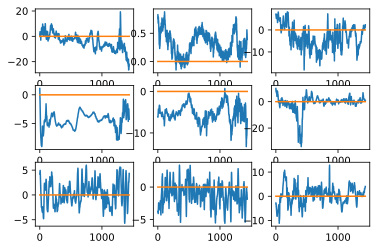

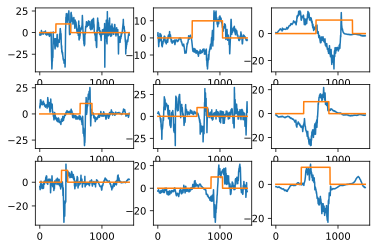

In [7]:
# import matplotlib.pyplot as plt

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_0[i][:,5])
    else:
        plt.plot(zs_0[i][:,0])
        
    plt.plot(10*locallabel_0[i])
    
plt.show()

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_1[i][:,5])
    else:
        plt.plot(zs_1[i][:,0])
    plt.plot(10*locallabel_1[i])

    
plt.show()

In [8]:
# data has been parsed, now run Manifolder

dim=6
H = 160
step_size = 20
nbins = 10
ncov = 10

start_time = time.time()

# create manifolder object
manifolder = mr.Manifolder(dim=dim,H=H,step_size=step_size,nbins=nbins, ncov=ncov)

# add the data, and fit (this runs all the functions)
manifolder.fit_transform(zs, parallel=False)

elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')  # about 215 seconds (four minutes)


calculating histograms for snip  0  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  1  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  2  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  3  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  4  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  5  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  6  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  7  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  8  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  9  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  10  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip

In [9]:
import pickle
with open('manifolder_multidim_6.pickle', 'wb') as f:
    pickle.dump(manifolder, f)


In [10]:
# calculate energy distance matrix for dimension reduced data from manifolder

snippet_psi = []
size = manifolder.Psi.shape[0] // len(zs)
for i in range(0, manifolder.Psi.shape[0], size):
    snippet_psi.append(manifolder.Psi[i:i+size, :])

import dcor
dcor_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(snippet_psi)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(snippet_psi[i], snippet_psi[j])
        dcor_dm[i,j] = distance
        dcor_dm[j,i] = distance
print('\n\t Dcor Executed in', str(np.round(time.time() - start_time, 2)), 'seconds')
print(dcor_dm)


	 Dcor Executed in 1.65 seconds
[[0.     4.663  2.7923 ... 3.4159 3.448  3.3294]
 [4.663  0.     4.5035 ... 4.4913 3.9321 4.2127]
 [2.7923 4.5035 0.     ... 0.5667 0.8203 0.5866]
 ...
 [3.4159 4.4913 0.5667 ... 0.     0.3201 0.4002]
 [3.448  3.9321 0.8203 ... 0.3201 0.     0.3698]
 [3.3294 4.2127 0.5866 ... 0.4002 0.3698 0.    ]]


In [11]:
locallabel_downsample = np.empty(0, float)
for i in range(len(locallabel)):
    x = locallabel[i]
    x = x[0:x.shape[0]-H]
    x = x[::step_size]

    locallabel_downsample = np.append(locallabel_downsample,x,0)
    
Psi = manifolder.Psi[:,0:manifolder.Dim]
    
print(locallabel_downsample.shape)
print(Psi.shape)

(6656,)
(6656, 6)


In [ ]:
class EmptyObject:
    pass

results = EmptyObject()
#results.manifolder = manifolder
results.psi = manifolder.Psi
results.dcor_dm = dcor_dm
results.locallabel_downsample = locallabel_downsample
import pickle
try:
    pfile = open(".\clusteringResults.pickle", "wb+")
    pickle.dump(results, pfile)
    pfile.close()
    print("Pickle file written successfully")
except Exception as ex:
    print(ex)
    print("Unable to write pickle file")
plt.scatter(manifolder.Psi[:,0],manifolder.Psi[:,2],c=locallabel_downsample,cmap='jet')

In [ ]:
print(results.dcor_dm.shape)

In [ ]:
from sklearn.cluster import KMeans
singledim = []
singleDimNumber = 0
for snippet in zs:
    singledim.append(snippet[:,singleDimNumber])

results = []
for i in range(1000):
    kmeans_orig = KMeans(n_clusters=2).fit(singledim)
    found = False
    for temp in results:
        if (kmeans_orig.labels_ == temp[0]).all() or (kmeans_orig.labels_ != temp[0]).all():
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeans_orig.labels_, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
cluster_out = results[-1][0]
print(cluster_out)
truePositive = 0
falsePositive = 0
trueNegative = 0
falseNegative=0
for i in range(len(zs_0)):
    if cluster_out[i] == 0:
        trueNegative += 1
    else:
        falsePositive += 1
for i in range(len(zs_0), len(zs)):
    if cluster_out[i] == 1:
        truePositive += 1
    else:
        falseNegative += 1
print("TN:", trueNegative)
print("FP:", falsePositive)
print("TP:", truePositive)
print("FN:", falseNegative)

In [12]:
# kmedoids clustering function

from pyclustering.cluster.kmedoids import kmedoids

def try_medoids(nclust, dm):
    len_data = dm.shape[0]
    initial_medoids = random.sample(range(len_data), nclust)
    kmedoids_instance = kmedoids(dm, initial_medoids, data_type = 'distance_matrix')
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    #print(clusters)
    clusters[0].sort()
    clusters[1].sort()
    return clusters

In [13]:
# calculate euclidean distance matrix for original data

euclid_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
for i in range(len(snippet_psi)):
    for j in range(i):
        distance = np.linalg.norm(zs[i] - zs[j])
        euclid_dm[i,j] = distance
        euclid_dm[j,i] = distance
print(euclid_dm)

[[     0.     128086.6914   8847.9686 ...  17729.6639 147513.2306
   22740.9606]
 [128086.6914      0.     125398.1357 ... 113347.2485  67699.7437
  113075.7471]
 [  8847.9686 125398.1357      0.     ...  15788.8607 145374.5769
   21209.4777]
 ...
 [ 17729.6639 113347.2485  15788.8607 ...      0.     134162.0477
   15303.7083]
 [147513.2306  67699.7437 145374.5769 ... 134162.0477      0.
  134406.1825]
 [ 22740.9606 113075.7471  21209.4777 ...  15303.7083 134406.1825
       0.    ]]


In [14]:
# kmedoids clustering using Euclidean distance

results = []
for i in range(10000):
    kmeds = try_medoids(2, euclid_dm)
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1])) or \
        (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
results = sorted(results, key=lambda array: array[1])

print("########################################################################")
print("before sorting")
print(results)
print("after sorting")
results = sorted(results, key=lambda array: array[1])
print(results)
print("########################################################################")



########################################################################
before sorting
[[[[0, 2, 4, 5, 6, 7, 8, 10, 11, 16, 17, 19, 20, 21, 23, 24, 28, 30, 32, 35, 38, 39, 40, 41, 42, 47, 48, 49, 50, 51, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 66, 68, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 90, 91, 92, 94, 95, 96, 97, 98, 100, 101, 103], [1, 3, 9, 12, 13, 14, 15, 18, 22, 25, 26, 27, 29, 31, 33, 34, 36, 37, 43, 44, 45, 46, 52, 56, 65, 67, 69, 76, 82, 89, 93, 99, 102]], 10000]]
after sorting
[[[[0, 2, 4, 5, 6, 7, 8, 10, 11, 16, 17, 19, 20, 21, 23, 24, 28, 30, 32, 35, 38, 39, 40, 41, 42, 47, 48, 49, 50, 51, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 66, 68, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 90, 91, 92, 94, 95, 96, 97, 98, 100, 101, 103], [1, 3, 9, 12, 13, 14, 15, 18, 22, 25, 26, 27, 29, 31, 33, 34, 36, 37, 43, 44, 45, 46, 52, 56, 65, 67, 69, 76, 82, 89, 93, 99, 102]], 10000]]
##############################################

In [15]:
# get results over all Monte Carlo bins for Euclidean

for i in range(len(results)):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative = 0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] >= len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


[[0, 2, 4, 5, 6, 7, 8, 10, 11, 16, 17, 19, 20, 21, 23, 24, 28, 30, 32, 35, 38, 39, 40, 41, 42, 47, 48, 49, 50, 51, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 66, 68, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 90, 91, 92, 94, 95, 96, 97, 98, 100, 101, 103], [1, 3, 9, 12, 13, 14, 15, 18, 22, 25, 26, 27, 29, 31, 33, 34, 36, 37, 43, 44, 45, 46, 52, 56, 65, 67, 69, 76, 82, 89, 93, 99, 102]]
TN: 25
FP: 46
TP: 11
FN: 22


In [16]:
# kmedoids clustering using manifolder+energy distance

results = []
for i in range(10000):
    kmeds = try_medoids(2, dcor_dm)
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1])) \
         or (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])

print("########################################################################")
print("before sorting")
print(results)
print("after sorting")
results = sorted(results, key=lambda array: array[1])
print(results)
print("########################################################################")


########################################################################
before sorting
[[[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], [37]], 7087], [[[0, 1, 3, 7, 9, 11, 12, 13, 14, 18, 21, 23, 25, 26, 27, 29, 31, 33, 34, 36, 37, 40, 43, 44, 45, 52, 65, 67, 74, 80], [2, 4, 5, 6, 8, 10, 15, 16, 17, 19, 20, 22, 24, 28, 30, 32, 35, 38, 39, 41, 42, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]], 2913]]
after sorting
[[[[0, 1, 3, 7, 9, 11, 12, 13, 14, 18, 21, 23, 25

In [17]:
# get results over all Monte Carlo bins for manifolder with energy distance

for i in range(len(results)):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] >= len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], [37]]
TN: 46
FP: 57
TP: 0
FN: 1
[[0, 1, 3, 7, 9, 11, 12, 13, 14, 18, 21, 23, 25, 26, 27, 29, 31, 33, 34, 36, 37, 40, 43, 44, 45, 52, 65, 67, 74, 80], [2, 4, 5, 6, 8, 10, 15, 16, 17, 19, 20, 22, 24, 28, 30, 32, 35, 38, 39, 41, 42, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]]
TN: 25
FP: 5
TP: 52
FN: 22


In [20]:
#kmedoids clustering using dtw, summing each dimension

from pyclustering.cluster.kmedoids import kmedoids
import pickle

try:
    f = open("dtw_distmat_snippets_all_dims_sum.pickle", 'rb')
    dtw_distmat_all_dims_sum = pickle.load(f)
finally:
    f.close()

results = []
for i in range(10000):
    kmeds = try_medoids(2, dtw_distmat_all_dims_sum)
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1]))\
         or (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
for i in range(len(results)):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] > len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


[[[[0, 1, 3, 7, 8, 11, 13, 16, 17, 18, 20, 21, 23, 25, 28, 29, 30, 35, 37, 41, 42, 43, 45, 50, 52, 53, 54, 55, 56, 57, 58, 60, 62, 64, 66, 67, 69, 70, 71, 73, 74, 76, 78, 79, 81, 82, 85, 88, 89, 90, 92, 93, 94, 95, 97, 98, 100, 101, 102], [2, 4, 5, 6, 9, 10, 12, 14, 15, 19, 22, 24, 26, 27, 31, 32, 33, 34, 36, 38, 39, 40, 44, 46, 47, 48, 49, 51, 59, 61, 63, 65, 68, 72, 75, 77, 80, 83, 84, 86, 87, 91, 96, 99, 103]], 4850], [[[2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 26, 27, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 59, 61, 62, 63, 65, 66, 68, 69, 71, 72, 73, 75, 77, 78, 80, 81, 82, 83, 84, 86, 87, 88, 89, 91, 93, 96, 98, 99, 100, 102, 103], [0, 1, 7, 8, 11, 16, 20, 25, 28, 30, 35, 41, 45, 52, 53, 58, 60, 64, 67, 70, 74, 76, 79, 85, 90, 92, 94, 95, 97, 101]], 5150]]
[[2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 26, 27, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51,

In [19]:
# kmedoids clustering using joint dtw

import pickle

try:
    f = open("dtw_distmat_snippets_all_dims.pickle", 'rb')
    dtw_distmat_all_dims = pickle.load(f)
finally:
    f.close()

results = []
for i in range(10000):
    kmeds = try_medoids(2, dtw_distmat_all_dims)
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1]))\
         or (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
for i in range(1):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] > len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


[[[[2, 5, 9, 10, 12, 14, 16, 19, 21, 22, 24, 26, 29, 33, 36, 37, 38, 40, 46, 60, 83, 99], [0, 1, 3, 4, 6, 7, 8, 11, 13, 15, 17, 18, 20, 23, 25, 27, 28, 30, 31, 32, 34, 35, 39, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103]], 10000]]
[[2, 5, 9, 10, 12, 14, 16, 19, 21, 22, 24, 26, 29, 33, 36, 37, 38, 40, 46, 60, 83, 99], [0, 1, 3, 4, 6, 7, 8, 11, 13, 15, 17, 18, 20, 23, 25, 27, 28, 30, 31, 32, 34, 35, 39, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103]]
TN: 19
FP: 3
TP: 53
FN: 29


In [21]:
snippet_windows = []

# create windows for multivariate energy distance
for snip in range(len(zs)):
    z = zs[snip]
    num_dims = z.shape[1]
    i_range = int(np.floor(z.shape[0] - H) / step_size)
    window = np.zeros((H, i_range*num_dims))
    #print(window.shape)
    for dim in range(num_dims):
        for i in range(i_range):
            # interval = z(dim, 1 + (i - 1) * stepSize: (i - 1) * stepSize + H);
            interval = z[i * step_size:i * step_size + H, dim]
            #print(interval.shape)
            window[:,dim+i*num_dims] = interval[:]
    snippet_windows.append(window)

print(snippet_windows)


import dcor
dcor_dm = np.zeros((len(zs), len(zs)))
start_time = time.time()
#snippet_windows = manifolder.get_windows()
for i in range(len(snippet_windows)):
    for j in range(i):
        distance = dcor.homogeneity.energy_test_statistic(snippet_windows[i], snippet_windows[j])
        dcor_dm[i,j] = distance
        dcor_dm[j,i] = distance
print('\n\t Dcor Executed in', str(np.round(time.time() - start_time, 2)), 'seconds')
print(dcor_dm)

[array([[ -8.59, -26.49,  21.  , ..., 195.28, 209.64, 204.85],
       [ -9.27, -26.01,  22.23, ..., 203.18, 207.9 , 206.33],
       [ -9.31, -26.43,  22.79, ..., 211.24, 206.44, 208.04],
       ...,
       [-15.02, -31.99, -16.84, ..., 409.94, 430.69, 423.77],
       [-15.43, -32.41, -18.18, ..., 416.44, 425.38, 422.4 ],
       [-15.8 , -32.  , -18.95, ..., 422.32, 419.66, 420.55]]), array([[   8.93,   -0.53,   25.49, ..., 1449.73, 1936.81, 1774.45],
       [   8.96,   -0.46,   25.45, ..., 1435.32, 1922.  , 1759.77],
       [   8.97,   -0.51,   25.45, ..., 1418.39, 1903.26, 1741.64],
       ...,
       [   8.36,   -0.38,   25.86, ..., 1401.76, 1949.73, 1767.07],
       [   8.35,   -0.41,   25.84, ..., 1404.64, 1954.1 , 1770.94],
       [   8.29,   -0.36,   25.9 , ..., 1408.51, 1959.57, 1775.88]]), array([[  8.1 ,   6.69, -25.2 , ..., 237.51, 375.55, 329.54],
       [  8.08,   7.13, -24.9 , ..., 237.54, 376.74, 330.34],
       [  8.06,   7.95, -24.42, ..., 237.54, 377.86, 331.09],
     


	 Dcor Executed in 194.49 seconds
[[      0.     4065127.7311  160342.7646 ...  484810.4984 4191590.885
   668416.4518]
 [4065127.7311       0.     3915375.8659 ... 3512893.3186 1353548.1127
  3508183.6704]
 [ 160342.7646 3915375.8659       0.     ...  374747.4189 4054180.3651
   577300.7074]
 ...
 [ 484810.4984 3512893.3186  374747.4189 ...       0.     3678048.5242
   373793.3062]
 [4191590.885  1353548.1127 4054180.3651 ... 3678048.5242       0.
  3684867.0742]
 [ 668416.4518 3508183.6704  577300.7074 ...  373793.3062 3684867.0742
        0.    ]]


In [22]:
# kmedoids clustering using energy distance

from pyclustering.cluster.kmedoids import kmedoids

results = []
for i in range(10000):
    kmeds = try_medoids(2, dcor_dm)
    found = False
    for temp in results:
        if (all(elem in temp[0][0] for elem in kmeds[0]) and all(elem in temp[0][1] for elem in kmeds[1]))\
         or (all(elem in temp[0][0] for elem in kmeds[1]) and all(elem in temp[0][1] for elem in kmeds[0])):
            temp[1] += 1
            found = True
            break
    if not found:
        results.append([kmeds, 1])
results = sorted(results, key=lambda array: array[1])
print(results)
for i in range(len(results)):
    cluster_out = results[len(results)-1-i][0]
    print(cluster_out)
    truePositive = 0
    falsePositive = 0
    trueNegative = 0
    falseNegative=0
    for i in range(len(cluster_out[0])):
        if cluster_out[0][i] < len(zs_0):
            trueNegative += 1
        else:
            falsePositive += 1
    for i in range(len(cluster_out[1])):
        if cluster_out[1][i] > len(zs_0):
            truePositive += 1
        else:
            falseNegative += 1
    print("TN:", trueNegative)
    print("FP:", falsePositive)
    print("TP:", truePositive)
    print("FN:", falseNegative)


[[[[1, 3, 9, 12, 13, 14, 15, 18, 22, 23, 25, 26, 27, 29, 31, 33, 34, 36, 37, 43, 44, 45, 46, 52, 55, 56, 58, 60, 64, 65, 67, 69, 76, 81, 82, 89, 93, 99, 102], [0, 2, 4, 5, 6, 7, 8, 10, 11, 16, 17, 19, 20, 21, 24, 28, 30, 32, 35, 38, 39, 40, 41, 42, 47, 48, 49, 50, 51, 53, 54, 57, 59, 61, 62, 63, 66, 68, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 83, 84, 85, 86, 87, 88, 90, 91, 92, 94, 95, 96, 97, 98, 100, 101, 103]], 10000]]
[[1, 3, 9, 12, 13, 14, 15, 18, 22, 23, 25, 26, 27, 29, 31, 33, 34, 36, 37, 43, 44, 45, 46, 52, 55, 56, 58, 60, 64, 65, 67, 69, 76, 81, 82, 89, 93, 99, 102], [0, 2, 4, 5, 6, 7, 8, 10, 11, 16, 17, 19, 20, 21, 24, 28, 30, 32, 35, 38, 39, 40, 41, 42, 47, 48, 49, 50, 51, 53, 54, 57, 59, 61, 62, 63, 66, 68, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 83, 84, 85, 86, 87, 88, 90, 91, 92, 94, 95, 96, 97, 98, 100, 101, 103]]
TN: 23
FP: 16
TP: 40
FN: 25


In [ ]:
#cross-check of DTW versus Matlab

import math
x = []
for i in range(1000):
    x.append(math.cos(2*math.pi*((3*i/1000)**2)))
y = []
for i in range(400):
    y.append(math.cos(2*math.pi*18*i/400))

import dtw
temp = dtw.dtw(x,y)
print(temp.distance)